# Example: Exploring Crosstalk Results

Last Verified to Run: 2023-04-26<br>
Verified Stack Release: w_2023_15

## Introduction

MixCOATL was developed to be compatible with the Butler Gen 3 Repository to organize and store the results of the crosstalk analyses. The purpose of this notebook is to serve as a tutorial for interacting with and exploring the Gen 3 Repository. The data products shown here were generated by running the `mixcoatl.crosstalkTask.CrosstalkSpotTask` on a number of images taken at the SLAC National Accelerator Laboratory during the integration and testing of the Rubin Observatory LSST Camera.

In [1]:
# This should match the verified version listed at the start of the notebook
! eups list -s lsst_distrib

   gdf42428520+6e1f2e8f29 	current w_latest w_2023_15 setup


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.colors import SymLogNorm
import numpy as np
from scipy.stats import binned_statistic

## DM Stack imports
from lsst.daf.butler import Butler

## MixCOATL imports
from mixcoatl.utils import AMP2SEG, SEG2AMP

## Gen 3 repo for BOT data
repo = '/sdf/group/rubin/repo/main'

## Exploring a Gen 3 Repository

A `Butler` object can be initialized using the filepath to the repository YAML file. The BOT Gen 3 repository is located at `/sdf/group/lsst/camera/IandT/repo_gen3/BOT_data` and accessible via the SLAC Shared Data Facility (SDF). While the `Butler` itself is used for retrieving a dataset from the repository, the `registry` is useful for performing queries on datasets, exploring "collections" of datasets, and determining dataset types.

In [3]:
butler = Butler(repo)
registry = butler.registry

Within the BOT repository there are large number of collections of various types (RUN, TAGGED, CALIBRATION, CHAINED). These include the main raw data collection (`LSSTCam/raw/all`), curated calibration collection (`LSSTCam/calib`), and collections corresponding to individual analysis runs. Below we use the `registry` to query and print only the RUN collections associated with the crosstalk analysis.

In [4]:
## Display collections in the repository
collections = list(registry.queryCollections('u/snyder18/*/crosstalk*'))
collections.sort()
                   
for collection in collections:
    print(collection)

u/snyder18/13198/crosstalk_analysis
u/snyder18/13198/crosstalk_analysis/20221025T191836Z
u/snyder18/13199/crosstalk_analysis
u/snyder18/13199/crosstalk_analysis/20221023T005204Z
u/snyder18/13224/crosstalk_spot
u/snyder18/13224/crosstalk_spot/20230417T231039Z
u/snyder18/13224/crosstalk_spot_test
u/snyder18/13224/crosstalk_spot_test/20230418T210406Z
u/snyder18/13241/crosstalk_satellite
u/snyder18/13241/crosstalk_satellite/20230413T225923Z
u/snyder18/13241/crosstalk_satellite_test
u/snyder18/13241/crosstalk_satellite_test/20230417T201047Z


When querying the repository for dataset references it is important to know the fields available for query. This can be determined using the `registry`.

In [5]:
## Display list of dataset fields
print(registry.dimensions["exposure"].RecordClass.fields)

exposure: 
  instrument: str
  id: int
  physical_filter: str
  obs_id: str
  exposure_time: float
  dark_time: float
  observation_type: str
  observation_reason: str
  day_obs: int
  seq_num: int
  seq_start: int
  seq_end: int
  group_name: str
  group_id: int
  target_name: str
  science_program: str
  tracking_ra: float
  tracking_dec: float
  sky_angle: float
  azimuth: float
  zenith_angle: float
  has_simulated: bool
  timespan: lsst.daf.butler.Timespan


## Crosstalk Analysis Results

To obtain the results corresponding to the analysis of the BOT Run 5 data, first the dataset references for the calibrated images within the corresponding collection are obtained using the `registry`, by specifying the dataset type and the collection.

For the crosstalk analysis, the relevant dataset types are:

* `raw`: The raw CCD image.
* `cpCrosstalkProc`: The post-ISR CCD image used for the crosstalk analysis.
* `bias`: The calibration superbias CCD image used during ISR.
* `crosstalkResults`: The crosstalk model parameters determined by the best fit model.
* `crosstalkSignals`: The source signal associated with each best fit model determination.
* `crosstalkRatios`: The background subtracted pixel-by-pixel ratios measured from each post-ISR CCD image.
* `crosstalkFluxes`: The source flux for each pixel-by-pixel ratio measurement.
* `backgroundResults`: The background model parameters determined by the best fit model.

### Crosstalk Image Example

As an example we will start with the collection `u/snyder18/13224/crosstalk_spot`, which is data acquisition run 13224 consisting of crosstalk images for a range of exposure times on four different CCDs (58, 76, 139, 166). To get the `cpCrosstalkProc` datasets we start by constructing an SQL-like query specifying the run number, detector, and observation type, as well as providing the RUN collection corresponding to the analysis of this data run.  The `registry.queryDatasets()` method is used to get a generator of the dataset references corresponding to our query that can be converted into a list and sorted by exposure ID.

In [6]:
## Define SQL-like repository query
run_num = 13224
detector = 58
where = "instrument='LSSTCam'" + \
    " and exposure.observation_type='xtalk'" + \
    " and detector={0}".format(detector) + \
    " and exposure.science_program='{0}'".format(run_num)
collections = 'u/snyder18/{0}/crosstalk_spot'.format(run_num)

## Get dataset references
dataset_refs = list(registry.queryDatasets('cpCrosstalkProc', collections=collections,
                                           where=where))
dataset_refs.sort(key=lambda x: x.dataId['exposure'])
print('Number of calibrated images: {0}'.format(len(dataset_refs)))

Number of calibrated images: 400


An example `cpCrosstalkProc` dataset is obtained by selecting a dataset reference from the list of dataset references and using the `butler.get()` method. Each crosstalk image consists of four larger spots projected onto four different CCD segments; this allows the measurement of crosstalk for 4 of the 16 CCD segments in a single image.

Text(0.5, 1.0, 'cpCrosstalkProc: 3021122000691')

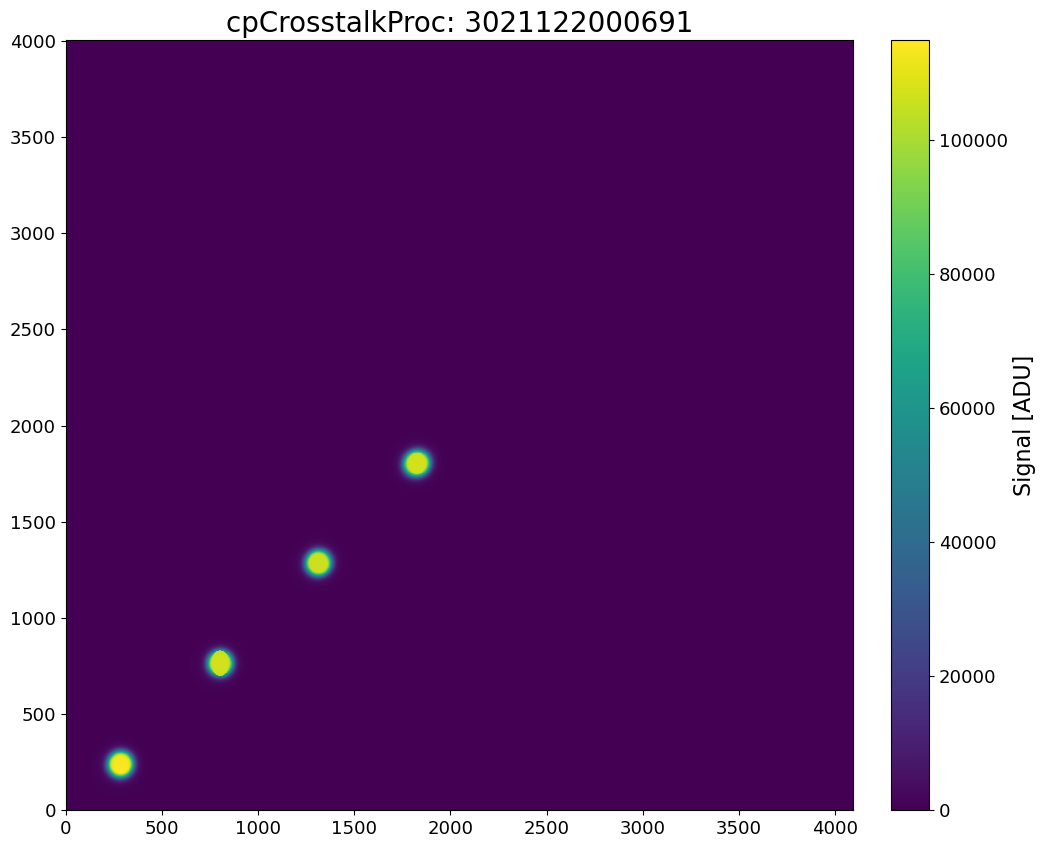

In [7]:
## Get single calibrated exposure
ref = dataset_refs[345]
calexp = butler.get(ref, collections=collections)

## Display calibrated image
fig, ax = plt.subplots(1, 1, figsize=(12, 10), facecolor='white')
im = ax.imshow(calexp.getImage().getArray(), interpolation='none', origin='lower')
    
cbar = fig.colorbar(im, fraction=0.046, pad=0.04)
cbar.set_label('Signal [ADU]', fontsize=16)
cbar.ax.tick_params(labelsize=13)
ax.tick_params(axis='both', which='major', labelsize=13)
ax.set_title('cpCrosstalkProc: {0}'.format(ref.dataId['exposure']), fontsize=20)

### Crosstalk Model Results

It is easy to obtain datasets associated with a specific dataset reference using the `butler.get()` method, although the syntax is modified slightly.  If we wish to obtain the `crosstalkResults` dataset, which contains all of the crosstalk model parameters calculated from the `cpCrosstalkProc` dataset, we must specify our desired dataset type and the data ID of the dataset reference.

In [8]:
## Get crosstalk model results
crosstalk_results = butler.get('crosstalkResults', dataId=ref.dataId, collections=collections)

The `crosstalkResults` dataset is a `StructuredDataDict` object, consisting of a set of nested dictionaries, containing crosstalk model parameters for source/target segment pairs identified in the calibrated image. The ordering of dictionary keys is target sensor id (e.g. `R13_S11`), source sensor name (identical to the target sensor), the target segment name (e.g. `C01`), and the source segment name (e.g. `C01`).  The source segment name indicates the segment where one of the large spots that serves as a source of crosstalk is located, while the target segment name refers to a different segment where we are measuring the amplitude of any induced electronic ghost.

The final dictionary contains the crosstalk model fit results for an individual source/target amplifier pair, consisting:

* `c0`: The linear crosstalk coefficient.
* `c0Error`: The parameter error estimate for the linear crosstalk coefficient.
* `c1`: The first-order non-linear crosstalk coefficient.
* `c1Error`: The parameter error estimate for the first-order non-linear crosstalk coefficient.

As an example, if we select the source amplifier to be C00 and target amplifier to be C01, crosstalk model results are as follows:

In [9]:
## Select sensor and source/target amplifier pair
raft_name, sensor_name = calexp.getDetector().getName().split('_')
sensor_id = '{0}_{1}'.format(raft_name, sensor_name)
source_segment = 'C00'
target_segment = 'C01'
amp_pair_results = crosstalk_results[sensor_id][sensor_id][target_segment][source_segment]

## Print dictionary items
print('{0}/{1} Crosstalk Results: {2},{3}'.format(raft_name, sensor_name, 
                                                  source_segment, target_segment))
for key, value in amp_pair_results.items():
    print('{0:<10} {1:>9.2E}'.format(key, value))

R13/S11 Crosstalk Results: C00,C01
c0          2.25E-04
c0Error     4.39E-06
c1         -4.14E-10
c1Error     3.41E-11


### Background Model Results

The `backgroundResults` dataset is a `StructuredDataDict` object with the same nested dictionary structure as the `crosstalkResults`. The final dictionary contains the background model fit results for an individual source/target segment pair consisting of:

* `b00`: The zero-th order background term (constant offset).
* `b00Error`: The parameter error estimate for the zero-th order background term.

If the background order used in the model fit was set to 1, the following parameters representing the 1st-order 2-D polynomial terms are included:

* `b01`: The first-order background term in the y-direction (slope in y-direction).
* `b01Error`: The parameter error estimate for the first-order background term in the y-direction.
* `b10`: The first-order background term in the x-direction (slope in x-direction).
* `b10Error`: The parameter error estimate for the first-order background term in the x-direction.

If the background order used in the model fit was set to 2, the following parameters representing the 2nd-order 2-D polynomial terms are included:

* `b02`: The second-order background term in the y-direction.
* `b02Error`: The parameter error estimate for the second-order background term in the y-direction.
* `b20`: The second-order background term in the x-direction.
* `b20Error`: The parameter error estimate for the second-order background term in the x-direction.
* `b11`: The second-order background cross term.
* `b11Error`: The parameter error estimate for the second-order background cross term.


As an example, if we select the source amplifier to be C00 and target amplifier to be C01, crosstalk model results are as follows:

In [10]:
## Get background model results
background_results = butler.get('backgroundResults', dataId=ref.dataId, collections=collections)

## Select sensor and source/target amplifier pair
raft_name, sensor_name = calexp.getDetector().getName().split('_')
sensor_id = '{0}_{1}'.format(raft_name, sensor_name)
source_segment = 'C00'
target_segment = 'C01'
amp_pair_results = background_results[sensor_id][sensor_id][target_segment][source_segment]

## Print dictionary items
print('{0}/{1} Background Results: {2},{3}'.format(raft_name, sensor_name, 
                                                   source_segment, target_segment))
for key, value in amp_pair_results.items():
    print('{0:<10} {1:>9.2E}'.format(key, value))

R13/S11 Background Results: C00,C01
b00         3.61E+01
b00Error    1.14E+00
b01        -8.45E-02
b10        -5.70E-02
b01Error    4.90E-03
b10Error    5.77E-03
b02         2.54E-04
b20         3.33E-05
b11         9.56E-06
b02Error    9.76E-06
b20Error    9.89E-06
b11Error    5.74E-06


## Crosstalk Calibration Results

For a single CCD there are 16 amplifiers and therefore 16x16 possible source/target segment pairs. A 16x16 crosstalk matrix can be constructed containing the crosstalk coefficient for each segment pair at a given source signal value. Using the example crosstalk image shown above, only four rows of of the 16x16 crosstalk matrix are populated, corresponding to the four possible source segments where the large spots are located. To populate the full matrix, at least 3 additional images are needed, corresponding to three different dither positions of the crosstalk projector.

Within a data repository the `crosstalk` dataset type is a calibration product containing the crosstalk matrix for each CCD, created by using `lsst.cp.pipe.measureCrosstalk.CrosstalkSolveTask` to aggregate and average the crosstalk ratio results.

To show this, a second dataset query is demonstrated, this time using the collection `u/snyder18/13199/crosstalk_analysis`, which is data run 13199 consisting of crosstalk images across all focal plane CCDs. While the previous data run stopped after calculating the crosstalk coefficients, this data run continued the analysis by using the `CrosstalkSolveTask` to aggregate and average the crosstalk coefficients for each CCD to generate the full crosstalk matrix.

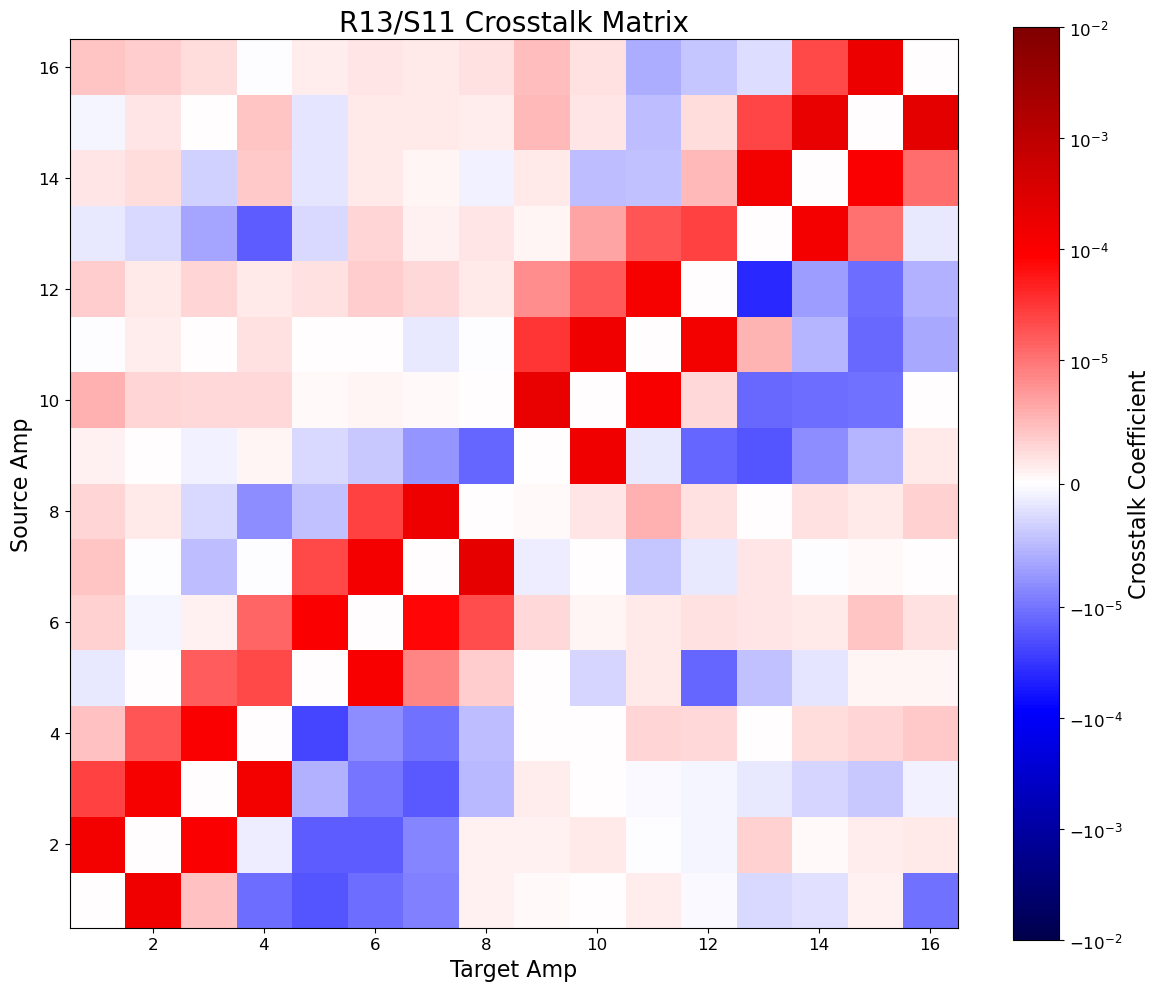

In [11]:
## Define SQL-like repository query
run_num = 13198
detector = 58
collections = 'u/snyder18/{0}/crosstalk_analysis'.format(run_num)
where = "instrument='LSSTCam'" + \
    " and detector={0}".format(detector)
collections = 'u/snyder18/{0}/crosstalk_analysis'.format(run_num)

## Get dataset references
dataset_refs = list(registry.queryDatasets('crosstalk', collections=collections,
                                        where=where))

## Get crosstalk calibration object
crosstalk_calib = butler.get(dataset_refs[0], collections=collections)
raft_name, sensor_name = crosstalk_calib.getMetadata()['DET_NAME'].split('_')

## Plot crosstalk matrix
fig, ax = plt.subplots(1, 1, figsize=(12, 10), facecolor='white')
im = ax.imshow(crosstalk_calib.coeffs.T, origin='lower', extent=[0.5, 16.5, 0.5, 16.5], 
               norm=SymLogNorm(1E-5, vmin=-1E-2, vmax=1E-2, base=10), cmap='seismic')
ax.tick_params(axis='both', labelsize=12)
ax.set_ylabel('Source Amp', fontsize=16)
ax.set_xlabel('Target Amp', fontsize=16)
ax.set_title('{0}/{1} Crosstalk Matrix'.format(raft_name, sensor_name), fontsize=20)
cbar = fig.colorbar(im)
cbar.ax.tick_params(labelsize=12) 
cbar.set_label('Crosstalk Coefficient', fontsize=16)
plt.tight_layout()